In [13]:
from fastcore.all import *
import time
import json

In [14]:
def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url, data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    headers = dict(referer='https://duckduckgo.com/')
    params = dict(
        l='us-en', 
        o='json', 
        q=term, 
        vqd=searchObj.group(1), 
        f=',,,', 
        p='1', 
        v7exp='a',
    )
    urls, data = set(), {'next': 1}

    while len(urls) < max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [15]:
urls = search_images('humming bird', max_images=1)
urls[0]

'https://www.familyhandyman.com/wp-content/uploads/2019/07/shutterstock_1028634766-bellied.jpg'

/home/stephen/miniconda3/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


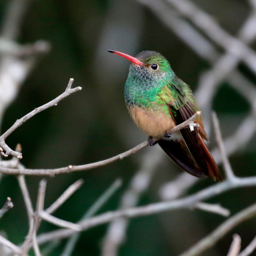

In [16]:
from fastdownload import download_url
dest = '../data/bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

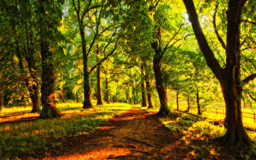

In [17]:
download_url(search_images('forest photos', max_images=1)[0], '../data/forest.jpg', show_progress=False)
Image.open('../data/forest.jpg').to_thumb(256,256)

In [19]:
searches = 'forest','bird'
path = Path('../data/bird_or_not')

In [ ]:
# Scrape images from DuckDuckGo
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

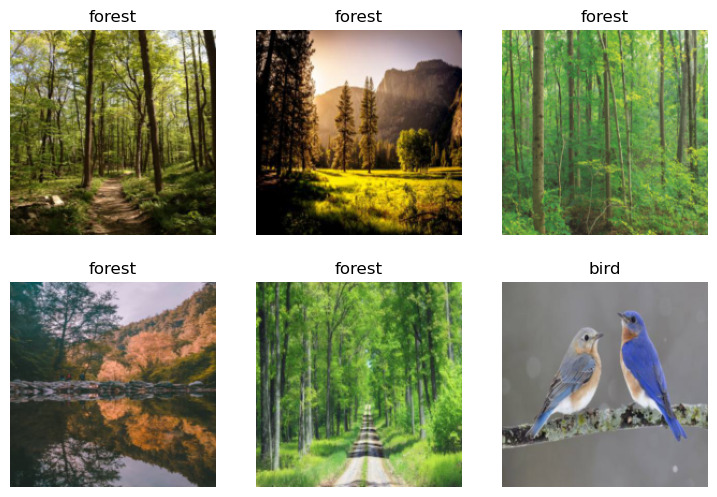

In [21]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/stephen/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/stephen/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/stephen/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 8.44MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.815678,1.158687,0.293333,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.091697,0.151831,0.066667,00:02
1,0.051880,0.009171,0.000000,00:01
2,0.037498,0.001379,0.000000,00:02


In [25]:
is_bird,_,probs = learn.predict(PILImage.create('../data/bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0000
